## dataload

In [1]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
import sys
sys.path.append('../LGBM')
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
from xgboost import XGBClassifier
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid1, valid2 = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid1.shape, valid2.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid1 = valid1.drop('answerCode',axis=1)
y_valid1 = valid1[['answerCode']]

x_valid2 = valid2.drop('answerCode',axis=1)
y_valid2 = valid2[['answerCode']]

x_train.shape, y_train.shape, x_valid1.shape, y_valid1.shape, x_valid2.shape, y_valid2.shape

((1845539, 86), (1845539, 1), (680417, 86), (680417, 1), (1974, 86), (1974, 1))

In [2]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'big_category_cum_solvesec', 'big_category_mean_solvesec',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'mid_category_cum_solvesec',
       'mid_category_mean_solvesec', 'problem_num_cumconut',
       'problem_num_answer', 'problem_num_user_cum_acc',
       'problem_num_cum_solvesec', 'problem_num_mean_solvesec', 'ass_acc_mean',
       'ass_acc_sum', 'ass_difficult

In [3]:
# MLflow 연결
remote_server_uri="http://118.67.134.110:30005"
mlflow.set_tracking_uri(remote_server_uri)
client = mlflow.tracking.MlflowClient()
experiment_name = "XGBM"
try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
experiment_id

'162010768050295210'

In [4]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,mid_category_solvesec_o,mid_category_solvesec_x,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,470.865257,374.856236,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,470.865257,374.856236,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,470.865257,374.856236,7,2,2.197225,1,0.428571,3,0,0


## XGBM 학습 및 예측

In [11]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600', 'time_category',
 'solvesec_cumsum', 'solvecumsum_category',
 'big_category',
 'big_category_cumconut', 'big_category_user_cum_acc', 'big_category_answer',
 'big_category_cum_solvesec', 'big_category_mean_solvesec',
 'bg_category_solvesec', 'bg_category_solvesec_o', 'bg_category_solvesec_x',
 'mid_category',
 'mid_category_cumconut', 'mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID','elo_problem_num',
 'ass_solvesec', 'ass_solvesec_o', 'ass_solvesec_x',
 'problem_num',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x']

xgbm_FEATS = FEATS

xgbm_cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
xgbm_cat_feats_idx = [i for i,e in enumerate(xgbm_FEATS) if e in xgbm_cat_feats]

xgbm_init_params = {
    "booster":"gbtree",
    "learning_rate": 0.023,
    "n_estimators" : 3200,
    "objective":"binary:logistic",
    "random_state": 42,
}

xgbm_fit_params = {
    "categorical_feature" : xgbm_cat_feats_idx
}

[0]	validation_0-auc:0.80410
[100]	validation_0-auc:0.81852
[200]	validation_0-auc:0.82302
[300]	validation_0-auc:0.82613
[400]	validation_0-auc:0.82827
[500]	validation_0-auc:0.82968
[600]	validation_0-auc:0.83033
[700]	validation_0-auc:0.83075
[800]	validation_0-auc:0.83127
[900]	validation_0-auc:0.83189
[1000]	validation_0-auc:0.83211
[1100]	validation_0-auc:0.83228
[1200]	validation_0-auc:0.83256
[1300]	validation_0-auc:0.83302
[1400]	validation_0-auc:0.83319
[1500]	validation_0-auc:0.83346
[1600]	validation_0-auc:0.83355
[1700]	validation_0-auc:0.83399
[1800]	validation_0-auc:0.83435
[1900]	validation_0-auc:0.83441
[2000]	validation_0-auc:0.83444
[2100]	validation_0-auc:0.83450
[2200]	validation_0-auc:0.83461
[2300]	validation_0-auc:0.83491
[2400]	validation_0-auc:0.83510
[2500]	validation_0-auc:0.83520
[2600]	validation_0-auc:0.83541
[2700]	validation_0-auc:0.83566
[2800]	validation_0-auc:0.83571
[2900]	validation_0-auc:0.83598
[3000]	validation_0-auc:0.83613
[3100]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.023, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

VALID AUC : 0.8364264964861172, ACC : 0.7553191489361702

writing prediction : output/12_08_Thu_XGBM_Test_피처_42개.csv


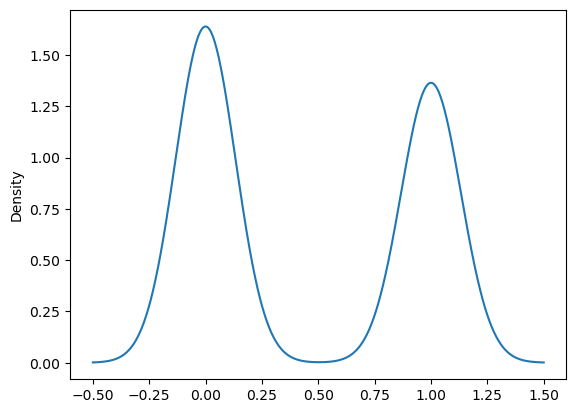

In [12]:
model = XGBClassifier(**xgbm_init_params)

mlflow.xgboost.autolog()

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[XGBM Test] 피처: {len(xgbm_FEATS)}개"
using_feats=", ".join(xgbm_FEATS)
desc=f"사용된 피처({len(xgbm_FEATS)})\n{using_feats}"

with mlflow.start_run(run_name=title, description=desc,experiment_id=experiment_id) as run:
    model = XGBClassifier(**xgbm_init_params)
    model.fit(
        x_train[xgbm_FEATS],
        y_train,
        eval_set=[(x_valid2[xgbm_FEATS],y_valid2)],
        eval_metric="auc",
        verbose=100,
    )
    preds = model.predict_proba(x_valid2[xgbm_FEATS])[:,1]
    acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
    auc2 = roc_auc_score(y_valid2, preds)
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, xgbm_FEATS, f'{file_name}.csv')
    
q = pd.Series(test_preds).plot(kind='kde')

In [19]:
eval_test = test[test.userID != test.userID.shift(-1)]

In [21]:
test_preds = model.predict_proba(eval_test[xgbm_FEATS])[:,1]

sub = pd.DataFrame(columns=['id','prediction'])
sub['id'] = list(range(744))

sub.prediction = test_preds

sub.to_csv('output/xgbm_sub.csv',index=False)

[0]	validation_0-auc:0.83643
[100]	validation_0-auc:0.83658
[200]	validation_0-auc:0.83675
[300]	validation_0-auc:0.83703
[394]	validation_0-auc:0.83700


2022/12/08 17:17:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: list index out of range


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.023, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

VALID AUC : 0.8364264964861172, ACC : 0.7553191489361702

writing prediction : output/12_08_Thu_XGBM_Test_추가학습_피처_42개.csv


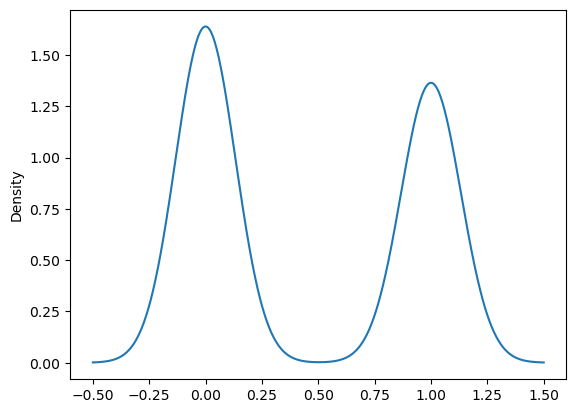

In [28]:
date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[XGBM Test 추가학습] 피처: {len(xgbm_FEATS)}개"
using_feats=", ".join(xgbm_FEATS)
desc=f"사용된 피처({len(xgbm_FEATS)})\n{using_feats}"

with mlflow.start_run(run_name=title, description=desc,experiment_id=experiment_id) as run:
    model2 = XGBClassifier(**xgbm_init_params)
    model2.fit(
        x_train[xgbm_FEATS],
        y_train,
        eval_set=[(x_valid2[xgbm_FEATS],y_valid2)],
        eval_metric="auc",
        early_stopping_rounds=100,
        verbose=100,
        xgb_model=model.get_booster()
    )
    preds = model.predict_proba(x_valid2[xgbm_FEATS])[:,1]
    acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
    auc2 = roc_auc_score(y_valid2, preds)
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, xgbm_FEATS, f'{file_name}.csv')
    
q = pd.Series(test_preds).plot(kind='kde')

In [29]:
preds = model2.predict_proba(x_valid2[xgbm_FEATS])[:,1]
acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
auc2 = roc_auc_score(y_valid2, preds)
print(f'VALID AUC : {auc2}, ACC : {acc}\n')

VALID AUC : 0.8370385457298507, ACC : 0.756838905775076



In [30]:
test_preds2 = model2.predict_proba(eval_test[xgbm_FEATS])[:,1]
sub = pd.DataFrame(columns=['id','prediction'])
sub['id'] = list(range(744))
sub.prediction = test_preds2

sub.to_csv('output/xgbm_sub_3600epoch.csv',index=False)

In [16]:
preds = model.predict_proba(x_valid2[xgbm_FEATS])[:,1]
acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
auc2 = roc_auc_score(y_valid2, preds)
auc2

0.8364264964861172

In [ ]:
model.fit(
        x_train[xgbm_FEATS],
        y_train,
        eval_set=[(x_valid2[xgbm_FEATS],y_valid2)],
        eval_metric="auc",
        verbose=100,
        xgb_model=model.get_booster()
    )

In [ ]:
params = {'objective': 'binary:logistic', 'use_label_encoder': False, 
          'seed': 27, 'eval_metric': 'logloss', 'n_estimators': best_est, 
          'learning_rate': best_lr, 'subsample': best_subsample}

# train iteration 1  below

model = XGBClassifier(**params)
model.fit(x_train_1, y_train_1)

# train iteration 2 below

model = model.fit(x_train_2, y_train_2, xgb_model=model.get_booster())

In [24]:
perm = PermutationImportance(
    model, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
).fit(x_valid2[xgbm_FEATS], y_valid2)
eli5.show_weights(perm, top=len(xgbm_FEATS), feature_names=xgbm_FEATS)

Weight,Feature
0.0251 ± 0.0000,solvesec_cumsum
0.0195 ± 0.0000,mid_category_cumconut
0.0162 ± 0.0000,elo_assessmentItemID
0.0144 ± 0.0000,mid_category
0.0108 ± 0.0000,assIdx
0.0097 ± 0.0000,dayname
0.0086 ± 0.0000,test_mean
0.0080 ± 0.0000,day
0.0054 ± 0.0000,user_total_answer
0.0051 ± 0.0000,KnowledgeTag
